## Selecting airport hubs for a new airline

The problem of facility location is common to industries that have physical locations ("facilities") and need to identify the best new location as their business grows. There are numerous examples of this, ranging from chain stores and restaurants trying to open new locations, to placing public electric car charging stations in cities and along well-traveled routes. A common thread among these examples is that, generally, many locations have already been picked out and cannot be moved. 

A simple strategy for placing locations would be to make selections based on their total (or expected) number of served people. However, depending on how a location is defined, this approach might leave people in smaller cities or lower density areas completely unserved. For instance, if locations were defined as small contiguous regions and choices made based on their population, some large cities are likely to get multiple locations.  Put another way, there may be redundancy among the people who are served.

A more complex strategy is to use a clustering method applied to data where each potential location is encoded as an example weighted by the number of people at the location. Using k-medoids with k being the number of locations that would be open guarantees that exact locations are picked and can try to minimize the redundancy among those served. However, clustering approaches have the significant downside that, when placing a new facility, one would have to re-run the clustering algorithm with a larger number of clusters. Given that it is likely impossible to move currently existing facilities in these locations, this approach does not seem feasible.

In contrast to traditional clustering approaches, submodular optimization provides an appealing framework for this task. Other notebooks in this repository go more in depth on the details of submodular optimization, but essentially, one can use a greedy approach that iteratives selects examples which minimize redundancy with those that have already been chosen. This property is convenient when you can't move previous facilities.

Let's say you're a new airline and you want to know where to put your hubs. You might want these hubs to be at locations that service the most routes so that you can minimize the distance an airplane has to fly to return to a hub. Initially, you might suspect that putting these hubs at the biggest cities is likely the best choice. However, since this notebook is being written as part of a tutorial on submodular optimization, you also suspect that submodular optimization might yield a better selection.

In [1]:
%pylab inline
numpy.random.seed(0)

import pandas
import seaborn; seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


### Loading the Data

We will be using two tables of data from openflights.org for this example. The first table contains information about airports around the world and the second table contains information about recorded routes. A limitation of this data is that it was updated most recently in 2014.

Let's first load up the airport table. Because we are focusing on the United States, we will filter out the airports from other parts of the world. This table includes a lot of information about each airport, but the only things we really need are the ID and the name, for human interpretability.

In [2]:
names = 'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source'
airports = pandas.read_csv("airports.csv", header=None, names=names)
airports = airports[airports['Country'] == 'United States']
airports.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
3212,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,PABA,70.134003,-143.582001,2,-9,A,America/Anchorage,airport,OurAirports
3213,3412,Wainwright Air Station,Fort Wainwright,United States,\N,PAWT,70.613403,-159.860001,35,-9,A,America/Anchorage,airport,OurAirports
3214,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,PALU,68.875099,-166.110001,16,-9,A,America/Anchorage,airport,OurAirports
3215,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,PPIZ,69.732903,-163.005005,22,-9,A,America/Anchorage,airport,OurAirports
3216,3415,Hilo International Airport,Hilo,United States,ITO,PHTO,19.721399,-155.048004,38,-10,N,Pacific/Honolulu,airport,OurAirports


Next, let's load up the routes. These routes include a source airport, which is where the flight began, and a destination airport, which is where the plane was flying to, as well as some other information that we can ignore.

In [3]:
names = 'Airline', 'Airline ID', 'Source ', 'Source ID', 'Destination', 'Destination ID', 'Codeshare', 'Stops', 'Equipment'
routes = pandas.read_csv("routes.csv", header=None, names=names)
routes = routes.replace("\\N", numpy.nan).dropna()
routes['Source ID'] = routes['Source ID'].astype(int)
routes['Destination ID'] = routes['Destination ID'].astype(int)
routes = routes.dropna()
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment
187,2P,897,GES,2402,MNL,2397,Y,0,320
197,2P,897,MNL,2397,GES,2402,Y,0,320
1059,4M,3201,DFW,3670,EZE,3988,Y,0,777
1060,4M,3201,EZE,3988,DFW,3670,Y,0,777
1061,4M,3201,EZE,3988,JFK,3797,Y,0,777


### Airport Visualization

We can start off by visualizing the location of each airport in our data set. There are a few airports that are in other countries that we can safely ignore because they are unlikely to be commercial.

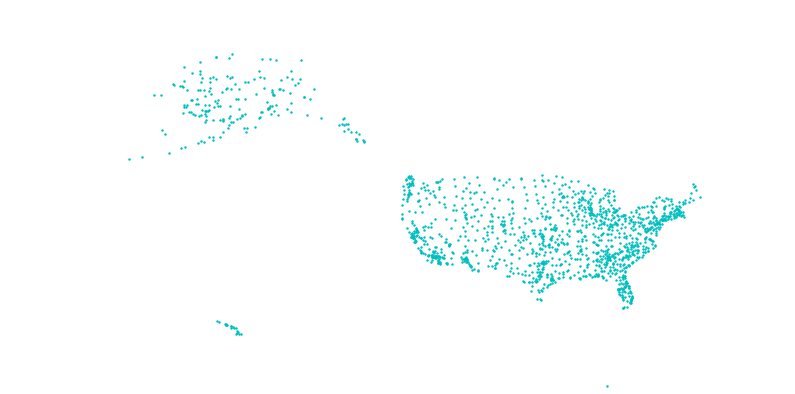

In [4]:
plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

That shape looks familiar.

Next, we can perform two table joins in order to get the latitude and longitude of the sorce and destination airports for each flight. This will let us visualize the routes.

In [5]:
routes_reduced = routes[['Source ID', 'Destination ID']].drop_duplicates()
airports_reduced = airports[['Airport ID', 'Latitude', 'Longitude']]

routes_merged = pandas.merge(routes_reduced, airports_reduced, left_on='Source ID', right_on='Airport ID')
routes_merged = pandas.merge(routes_merged, airports_reduced, left_on='Destination ID', right_on='Airport ID', suffixes=('_source', '_destination'))
routes_merged = routes_merged.drop(['Airport ID_destination', 'Airport ID_source'], axis=1)
routes_merged.head()

,Source ID,Destination ID,Latitude_source,Longitude_source,Latitude_destination,Longitude_destination
0,3670,3718,32.896801,-97.038002,32.411301,-99.681900
1,3670,3700,32.896801,-97.038002,31.611300,-97.230499
2,3670,3852,32.896801,-97.038002,31.327400,-92.549797
3,3682,3852,33.636700,-84.428101,31.327400,-92.549797
4,3550,3852,29.984400,-95.341400,31.327400,-92.549797


Now let's add the routes to the plot as thin lines.

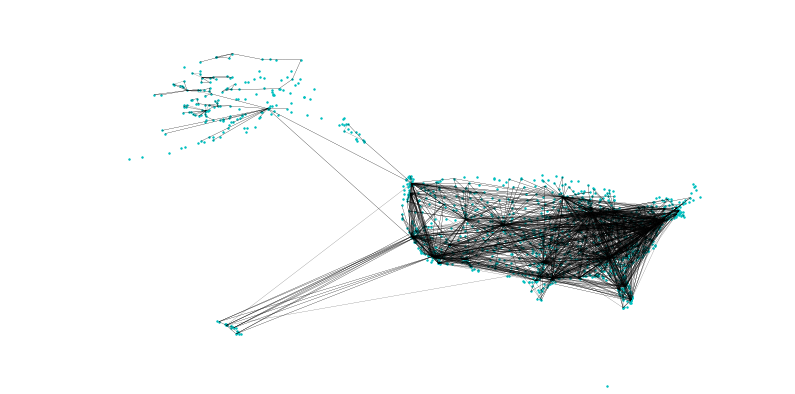

In [6]:
plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
for i, (_, _, la_x, lo_x, la_y, lo_y) in routes_merged.iterrows():
    plt.plot([lo_x, lo_y], [la_x, la_y], color='k', linewidth=0.15)
    
plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

We can already see some hubs forming. It looks like Atlanta is a clear hub near the east coast, Chicago is a clear hub north of it, Houston is a hub in the south, and Los Angeles is a clear hub on the west coast.

### Airport selection using the most routes

As a baseline, let's see how many routes are covered by those airports that are connected to the most routes. In this case, we're saying that an airport covers a route if it is either the source or the destination of the routes in the data set. We can do this by creating a matrix where each row and column are airports and a 1 indicates that there is a route connected the two airports. This will result in a square symmetric matrix.

In [7]:
n = len(airports)
mapping = {airport: i for i, airport in enumerate(airports['Airport ID'])}

route_map = numpy.zeros((n, n))
for _, (source, destination) in routes_reduced.iterrows():
    if source in mapping and destination in mapping:
        x, y = mapping[source], mapping[destination]
        route_map[x, y] = 1
        route_map[y, x] = 1
        
route_map.sum()

3404.0

Looks like there are 3404 total routes in our data base.

What are the 6 airports connected to the most routes?

In [8]:
airports_w_routes = airports.copy()
airports_w_routes['# Routes'] = [route_map[mapping[airport]].sum() for airport in airports['Airport ID']]
airports_w_routes.sort_values("# Routes", ascending=False).head(6)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,# Routes
3482,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,1026,-5,A,America/New_York,airport,OurAirports,146.0
3630,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6,A,America/Chicago,airport,OurAirports,117.0
3551,3751,Denver International Airport,Denver,United States,DEN,KDEN,39.861698,-104.672997,5431,-7,A,America/Denver,airport,OurAirports,107.0
3658,3858,Minneapolis-St Paul International/Wold-Chamber...,Minneapolis,United States,MSP,KMSP,44.882000,-93.221802,841,-6,A,America/Chicago,airport,OurAirports,79.0
3470,3670,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,DFW,KDFW,32.896801,-97.038002,607,-6,A,America/Chicago,airport,OurAirports,76.0
3350,3550,George Bush Intercontinental Houston Airport,Houston,United States,IAH,KIAH,29.984400,-95.341400,97,-6,A,America/Chicago,airport,OurAirports,71.0


These airports are fairly expected. Atlanta is the busiest airport in the United States, so it's not surprising that it comes up first. Further, Delta has hubs in Atlanta and Minneapolis-St Paul (among other cities), United has hubs in Chicago, Denver, and Houston. Lastly, Dallas is a hub for American. Thus, all of the top 6 airports here currently serve as hubs for some airline.

What do these airports look like if we plotted their location as well as all the routes that are connected to them?

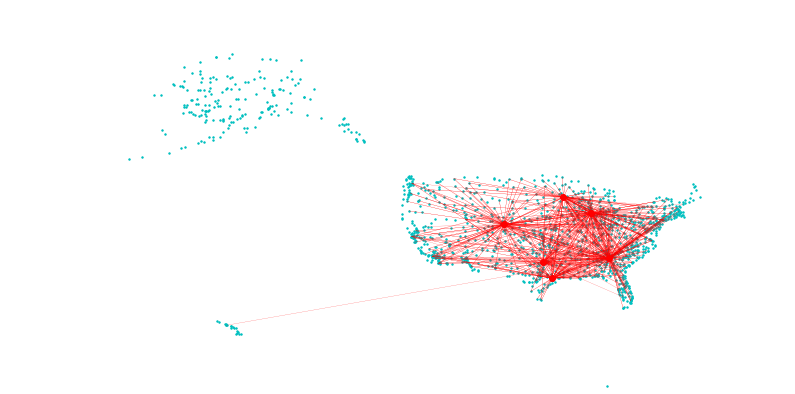

In [9]:
airports_ = airports_w_routes.sort_values("# Routes", ascending=False).head(6)
airport_idxs = airports_['Airport ID'].values
d = {}

plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
plt.scatter(airports_['Longitude'], airports_['Latitude'], color='r')

for i, (sid, did, la_x, lo_x, la_y, lo_y) in routes_merged.iterrows():
    if (sid, did) in d:
        continue
        
    if int(sid) in airport_idxs or int(did) in airport_idxs:
        d[(sid, did)] = True
        plt.plot([lo_x, lo_y], [la_x, la_y], color='r', linewidth=0.15)

plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

The selected airports seem to be concentrated in the mid-west and ~east. This makes sense, because airports in the middle of the country are well suited for supporting flights to either coast. However, you'll notice that these airports do not serve any of the airports in Alaska or lie at all on the west coast.

Let's evaluate this choice of airports by summing the total number of unique airports that they are connected to. This means that if both Atlanta and Chicago have flights to Seattle that the pair only gets 1 point.

In [10]:
most_routes = numpy.array([mapping[airport] for airport in airport_idxs[:6]])
route_map[most_routes].max(axis=0).sum()

256.0

It looks like this set of airport hubs service 256 unique airports across the United States. Can we do better with submodular optimization?

### Airport selection by optimizing a facility location function
 
There are many submodular functions that one could optimize for this problem. However, the problem of placing facilities is such a canonical use of submodular optimization that there is a function named the "facility location" function. The functiont takes the form

\begin{equation}
f(X) = \sum\limits_{x} \max\limits_{y} \phi(x, y)
\end{equation}
where $x$ is an example from your data set, or potential locations in this case, $y$ is a facility that has already been selected, and $\phi$ is a similarity measure. Potentially similarity is the physical distance between $x$ and $y$.

Now let's use facility location to select the set of six airports. We can directly use the route map matrix that we made early as a precomputed similarity matrix, with airports having a route between them being "similar" and those not having routes connecting them being "dissimilar."

In [11]:
from apricot import FacilityLocationSelection

model = FacilityLocationSelection(6, pairwise_func='precomputed')
model.fit(route_map)

airports_w_routes.iloc[model.ranking].head(6)

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source,# Routes
3482,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,1026,-5,A,America/New_York,airport,OurAirports,146.0
3551,3751,Denver International Airport,Denver,United States,DEN,KDEN,39.861698,-104.672997,5431,-7,A,America/Denver,airport,OurAirports,107.0
3630,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6,A,America/Chicago,airport,OurAirports,117.0
3470,3670,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,DFW,KDFW,32.896801,-97.038002,607,-6,A,America/Chicago,airport,OurAirports,76.0
3399,3599,Bethel Airport,Bethel,United States,BET,PABE,60.779800,-161.837997,126,-9,A,America/Anchorage,airport,OurAirports,17.0
3377,3577,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,433,-8,A,America/Los_Angeles,airport,OurAirports,53.0


Naturally, this approach will select Atlanta first, due in part to its greedy nature which begins by selecting the single most representative example. In this case, the most representative airport is the one connected to the most other airports. 

The two major differences between selecting the airports with the most routes and optimizing a facility location function are differences in ranking, with Denver being selected this time ahead of Chicago, and the inclusion of Bethel and Seattle instead of Houston and Minneapolis-St. Paul. The inclusion of Bethel is interesting because, by itself, it is connected to few routes in comparison to the other selected airports. However, each of these routes is connected to a new airport, whereas other airports are connected to airports that likely alrady have flights to Atlanta, Denver, or Chicago. Finally, this approach selects Seattle to be a hub, which is so obviously correct that it needs no further elaboration here.

What do these airports look like on the map, along with the routes connected to them?

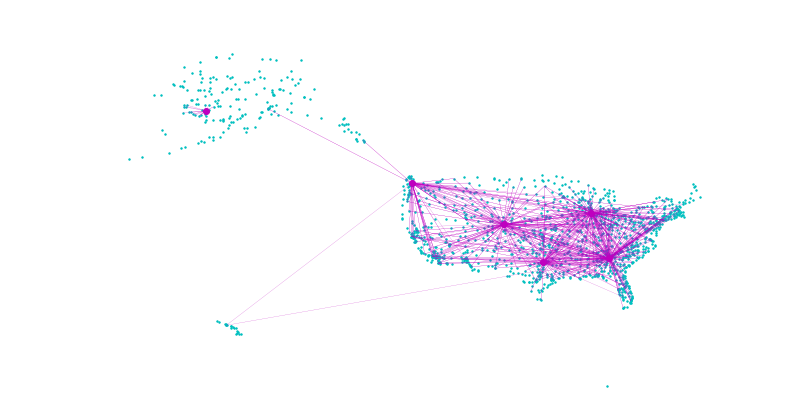

In [12]:
airports_ = airports_w_routes.iloc[model.ranking]
airport_idxs = airports_['Airport ID'].values
d = {}

plt.figure(figsize=(14, 7))
plt.scatter(airports['Longitude'], airports['Latitude'], s=2, color='c')
plt.scatter(airports_['Longitude'], airports_['Latitude'], color='m')

for i, (sid, did, la_x, lo_x, la_y, lo_y) in routes_merged.iterrows():
    if (sid, did) in d:
        continue
    
    if int(sid) in airport_idxs or int(did) in airport_idxs:
        d[(sid, did)] = True
        plt.plot([lo_x, lo_y], [la_x, la_y], color='m', linewidth=0.15)

plt.xlim(-200, -50)
plt.ylim(10, 80)

plt.axis('off')
plt.show()

The airports appear to be more evenly spaced across the US. The largest visible difference is more activity on the west coast, particularly the inclusion of more airports from Alaska.

In [13]:
most_routes = numpy.array([mapping[airport] for airport in airport_idxs[:6]])
route_map[most_routes].max(axis=0).sum()

270.0

Looks like we're up to 270 from the 256 before. While it may not seem like much initially, keep in mind that there are many routes that most large airports will be connected to. For instance, Atlanta alone is connected to more than half of the airports that this set of hubs is connected to. 

### Concluding remarks

The example here is clearly a toy example. In reality, one would want to factor in many more aspects of each location before deciding on hubs, such as the price of setting up a hub at each airport, the population served, the number of flights that they could reasonably fly out of each airport, and international or shipping routes. Further, the number of airports connected to a set of hub might not be the only metric one would use. However, it is a simple example of submodular optimization for placing facilities.